In [22]:
import cPickle as pickle
from download_songs import BinacaYear, Song
import glob
import collections
from pylab import *
import matplotlib
import matplotlib.pyplot as plt

In [2]:
binaca_year = {}
for i in glob.glob("./songs/*.p"):
    binaca_year[int(i[-6:-2])] = pickle.load(open(i, "rb"))


In [37]:
binaca_dict = {}
for year in binaca_year.keys():
    binaca_dict[year] = analyse(binaca_year[year])


In [34]:
def analyse(by):
    word_list = collections.defaultdict(float)
    
    for song in by.songs:
        for word in song.lyrics.split():
            word_list[word] += 1
    
    total_words = sum(word_list.values())
    word_list = {k: v/total_words for k, v in word_list.iteritems()}
    return word_list


In [46]:
vocab = set()
for keys in binaca_dict.values():
    for i in keys.keys():
        vocab.add(i)


In [79]:
def combine_dict(year_range):
    d = collections.defaultdict(float)
    for year in year_range:
        for k, v in binaca_dict[year].iteritems():
            d[k] += v
    return d

def get_top_n_words(n, year_range):
    d = combine_dict(year_range)
    m = [[v, k] for k, v in d.iteritems()]
    m.sort(reverse=True)
    return set(map(lambda i: i[1], m[n]))

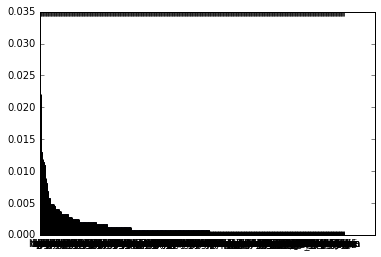

In [43]:
d = binaca_dict[1954]
m = [(v, k) for k, v in d.iteritems()]
m.sort(reverse=True)
x = range(len(m))
plt.bar(x, map(lambda i: i[0], m), 1/1.5, color="blue")
plt.xticks(x, map(lambda i: i[1], m))
show()

In [80]:
#see how words changed over time

s_v = slice(100, 200)
seta = get_top_n_words(s_v, range(1955, 1965))
setb = get_top_n_words(s_v, range(1973, 1983))

for i in seta:
    if i not in setb:
        print i, ',',
print
print '-' * 94

for i in setb:
    if i not in seta:
        print i, ',',
print

bhee , mila , maine , dhire , di , jaago , aaye , bat , magar , sang , chaand , bahar , ban , gagan , haay , nain , are , najar , jamuna , ichak , kyaa , phul , ruk , kee , kaun , liye , bol , haa , rang , diye , ghar , bhayo , hamara , tumhe , kahe , mora , more , manzil , yaha , yahi , gam , chup , gayo , ram , ik , barse , haye , dana , kyo , karu , sab , is , in , kuch , hame , sar , hindustani , kah , jiya , kiya , ho, , jaise , bade , tumse , sa , tha ,
----------------------------------------------------------------------------------------------
raja , mehbuba , chori , hath , ga , nahin , la , hay , jaa , bin , apna , jayenge , maar , mujhko , apne , du , bas , sanam , ru , aate , jaate , bole , dekha , ji , jate , se, , jata , jaan , jay , chor , bhai , dono , prem , tujhe , kahi , me, , jana , jhum , gori , he , ma , aao , aai , aap , kahaan , zara , badal , chale , raha , aha , karo , tak , saath , mil , hoo , shaadi , nam , jivan , mat , kal , kaise , aisa , aise , bina , t